<a href="https://colab.research.google.com/github/M22AIE212/MajorProject_SpeechUnderstanding/blob/main/Speech_Undertsanding_Major_Project_EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/M22AIE212/MajorProject_SpeechUnderstanding.git

Cloning into 'MajorProject_SpeechUnderstanding'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 369.85 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp "/content/drive/MyDrive/Speech Understanding/A3/test-gram.zip" /content

In [6]:
!unzip /content/test-gram.zip

Archive:  /content/test-gram.zip
   creating: content/LibriSpeech/test-gram/
   creating: content/LibriSpeech/test-gram/1/
  inflating: content/LibriSpeech/test-gram/1/09e69cbb2d6a4329a1c4cbe23296abcc.png  
  inflating: content/LibriSpeech/test-gram/1/aeaef88aaddd4a7fa1b5d29f0da68b65.png  
  inflating: content/LibriSpeech/test-gram/1/346b087e6c8a427ea78774164644bb15.png  
  inflating: content/LibriSpeech/test-gram/1/62660c1efef94f75b82cf1d2dda07481.png  
  inflating: content/LibriSpeech/test-gram/1/aef40bb89cb24f2f9be00b502053725a.png  
  inflating: content/LibriSpeech/test-gram/1/ccb6645e29fd4d308d0a8b2151ced3a0.png  
  inflating: content/LibriSpeech/test-gram/1/1e2dd4140d2049ca87b6ba59c3727500.png  
  inflating: content/LibriSpeech/test-gram/1/4e8c9d4679d743b0bbde0b32eb108cdc.png  
  inflating: content/LibriSpeech/test-gram/1/fa134946412148bd8ad50d7b7cf051fa.png  
  inflating: content/LibriSpeech/test-gram/1/e9887e39f9ba45fb9403f36ee3f5e202.png  
  inflating: content/LibriSpeech/test

## Evaluation

In [7]:
%matplotlib inline
import os
import sys
sys.path.append("/content/MajorProject_SpeechUnderstanding")
import numpy as np
import random
import matplotlib.pyplot as plt
from time import time

import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from utils import imshow,show_plot,plotting,Config
from custom_dataset import CustomDataset
from model import SiameseNetwork
from loss import CustomCrossEntropyLoss
from train import train_model
from eval import evaluate_model


print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

if __name__ =="__main__" :

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  trained_model_path = '/content/drive/MyDrive/Speech Understanding/A3/siamese_net_crossEntropy.pt'

  ## Train and Test Datasets and Dataloaders

  folder_dataset_test = dataset.ImageFolder(root="/content/content/LibriSpeech/test-gram")
  test_dataset = CustomDataset(imageFolderDataset=folder_dataset_test,
                                          transform=transforms.Compose([#transforms.Resize((100,100)),
                                                                        transforms.ToTensor()
                                                                        ])
                                        ,should_invert=False)

  test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

  ## Model , Loss and Optimizer Initialization
  model = SiameseNetwork().to(device)
  model.load_state_dict(torch.load(trained_model_path,map_location=torch.device('cpu')))


Version 2.2.1+cu121
CUDA enabled: False


In [43]:
from tqdm import tqdm
import torch.nn as nn
model_scores = []
target_label_list = []
with torch.no_grad():
    for batch_idx, (input_data0, input_data1, target_label) in enumerate(tqdm(test_dataloader)):
        input_data0, input_data1, target_label = input_data0.to(device), input_data1.to(device), target_label.to(device)
        model_output = model(input_data0, input_data1)
        model_scores.extend(model_output[:,1].numpy())
        target_label_list.extend(list(target_label.numpy()))

100%|██████████| 3/3 [00:35<00:00, 12.00s/it]


In [47]:
from sklearn.metrics import det_curve,RocCurveDisplay,auc,roc_curve

## EER
def compute_eer(truth, scores):
  frr, far, th = det_curve(truth, scores)
  abs_diffs = np.abs(frr - far)
  min_index = np.argmin(abs_diffs)
  eer = np.mean((frr[min_index], far[min_index]))
  return eer


## ROC - AUC
def plot_roc_curve_with_auc(truth, scores):
  fpr, tpr, thresholds = roc_curve(truth,scores)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
  display.plot()
  plt.title("ROC curve with AUC score : ")
  plt.show()

In [48]:
compute_eer(target_label_list,model_scores)

0.19784603302302417

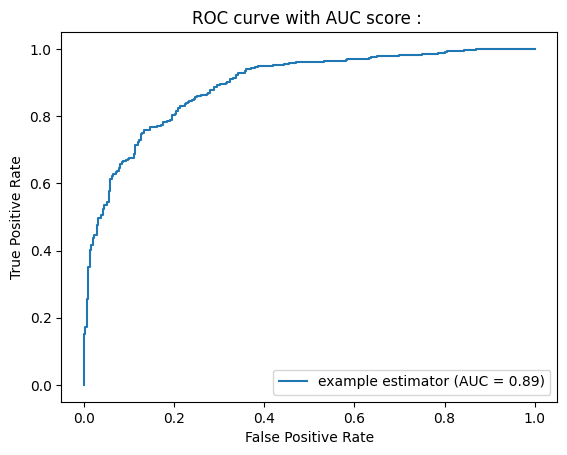

In [49]:
plot_roc_curve_with_auc(target_label_list,model_scores)

In [15]:
model.load_state_dict(torch.load(trained_model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
  criterion = CustomCrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  ## Training Loop
  train_loss_list = []
  test_loss_list = []
  train_accuracy_list = []
  test_accuracy_list = []

  for current_epoch in range(0, EPOCHS):
      print("Epoch number: ", current_epoch)
      start_time = time()

      print("\nTraining:")
      train_loss, train_accuracy = train_model(model, device, train_dataloader, current_epoch, optimizer, criterion)

      print("\nTesting:")
      test_loss, test_accuracy = evaluate_model(model, device, test_dataloader, criterion)

      train_loss_list.append((current_epoch, train_loss))
      test_loss_list.append((current_epoch, test_loss))
      train_accuracy_list.append((current_epoch, train_accuracy))
      test_accuracy_list.append((current_epoch, test_accuracy))

      torch.save(model.state_dict(), 'siamese_net_crossEntropy.pt')
      end_time = time()
      print("Time taken for running epoch {} is {:.3f} seconds.\n\n".format(current_epoch, end_time-start_time))


Version 2.2.1+cu121
CUDA enabled: True
Epoch number:  0

Training:


 33%|███▎      | 1/3 [00:03<00:07,  3.82s/it]

Train Epoch: 0 [256/721 (33%)]	Loss: 0.688421	Train Accuracy: 54.296875


100%|██████████| 3/3 [00:06<00:00,  2.25s/it]



Train set: Average loss = 7.5582, Train Accuracy = 51.7337


Testing:


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Test set: Average loss = 0.8186, Test Accuracy = 58.4235

Time taken for running epoch 0 is 15.185 seconds.


Epoch number:  1

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.41s/it]

Train Epoch: 1 [256/721 (33%)]	Loss: 7.955367	Train Accuracy: 45.703125


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]



Train set: Average loss = 5.7571, Train Accuracy = 59.5007


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]



Test set: Average loss = 1.5764, Test Accuracy = 59.5054

Time taken for running epoch 1 is 13.058 seconds.


Epoch number:  2

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.36s/it]

Train Epoch: 2 [256/721 (33%)]	Loss: 3.557266	Train Accuracy: 71.484375


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]



Train set: Average loss = 4.3639, Train Accuracy = 70.0416


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]



Test set: Average loss = 1.8472, Test Accuracy = 65.8423

Time taken for running epoch 2 is 12.936 seconds.


Epoch number:  3

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.25s/it]

Train Epoch: 3 [256/721 (33%)]	Loss: 4.455784	Train Accuracy: 73.437500


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]



Train set: Average loss = 4.5624, Train Accuracy = 73.5090


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]



Test set: Average loss = 3.5032, Test Accuracy = 56.8779

Time taken for running epoch 3 is 12.935 seconds.


Epoch number:  4

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]

Train Epoch: 4 [256/721 (33%)]	Loss: 3.743769	Train Accuracy: 77.343750


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]



Train set: Average loss = 3.0202, Train Accuracy = 80.0277


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]



Test set: Average loss = 3.4535, Test Accuracy = 64.2968

Time taken for running epoch 4 is 12.802 seconds.


Epoch number:  5

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.46s/it]

Train Epoch: 5 [256/721 (33%)]	Loss: 3.608955	Train Accuracy: 80.468750


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]



Train set: Average loss = 3.1320, Train Accuracy = 81.4147


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]



Test set: Average loss = 3.7798, Test Accuracy = 68.0062

Time taken for running epoch 5 is 13.029 seconds.


Epoch number:  6

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.26s/it]

Train Epoch: 6 [256/721 (33%)]	Loss: 2.861321	Train Accuracy: 81.640625


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]



Train set: Average loss = 2.6174, Train Accuracy = 83.4951


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]



Test set: Average loss = 5.1598, Test Accuracy = 67.0788

Time taken for running epoch 6 is 12.852 seconds.


Epoch number:  7

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.12s/it]

Train Epoch: 7 [256/721 (33%)]	Loss: 2.279164	Train Accuracy: 82.421875


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]



Train set: Average loss = 2.2677, Train Accuracy = 81.2760


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]



Test set: Average loss = 5.6120, Test Accuracy = 67.3879

Time taken for running epoch 7 is 12.715 seconds.


Epoch number:  8

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.01s/it]

Train Epoch: 8 [256/721 (33%)]	Loss: 1.603064	Train Accuracy: 84.375000


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]



Train set: Average loss = 1.9487, Train Accuracy = 84.4660


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]



Test set: Average loss = 4.3350, Test Accuracy = 71.4065

Time taken for running epoch 8 is 12.907 seconds.


Epoch number:  9

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.98s/it]

Train Epoch: 9 [256/721 (33%)]	Loss: 1.425316	Train Accuracy: 85.156250


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]



Train set: Average loss = 1.5231, Train Accuracy = 86.9626


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Test set: Average loss = 5.5533, Test Accuracy = 67.2334

Time taken for running epoch 9 is 12.602 seconds.


Epoch number:  10

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.90s/it]

Train Epoch: 10 [256/721 (33%)]	Loss: 0.983201	Train Accuracy: 87.109375


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]



Train set: Average loss = 1.3026, Train Accuracy = 84.8821


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Test set: Average loss = 6.4339, Test Accuracy = 64.2968

Time taken for running epoch 10 is 12.617 seconds.


Epoch number:  11

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

Train Epoch: 11 [256/721 (33%)]	Loss: 1.024942	Train Accuracy: 86.328125


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]



Train set: Average loss = 1.0618, Train Accuracy = 86.6852


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]



Test set: Average loss = 3.5628, Test Accuracy = 72.1793

Time taken for running epoch 11 is 12.696 seconds.


Epoch number:  12

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.85s/it]

Train Epoch: 12 [256/721 (33%)]	Loss: 1.173797	Train Accuracy: 89.453125


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]



Train set: Average loss = 0.9527, Train Accuracy = 90.1526


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



Test set: Average loss = 2.8669, Test Accuracy = 71.2519

Time taken for running epoch 12 is 20.815 seconds.


Epoch number:  13

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.87s/it]

Train Epoch: 13 [256/721 (33%)]	Loss: 0.745827	Train Accuracy: 91.406250


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]



Train set: Average loss = 0.8893, Train Accuracy = 90.4300


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]



Test set: Average loss = 2.7798, Test Accuracy = 72.3338

Time taken for running epoch 13 is 161.357 seconds.


Epoch number:  14

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.96s/it]

Train Epoch: 14 [256/721 (33%)]	Loss: 0.560241	Train Accuracy: 90.234375


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



Train set: Average loss = 0.8474, Train Accuracy = 87.6560


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]



Test set: Average loss = 4.1631, Test Accuracy = 63.5240

Time taken for running epoch 14 is 203.683 seconds.


Epoch number:  15

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.44s/it]

Train Epoch: 15 [256/721 (33%)]	Loss: 0.604704	Train Accuracy: 89.843750


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]



Train set: Average loss = 0.5938, Train Accuracy = 88.7656


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]



Test set: Average loss = 2.6693, Test Accuracy = 73.4158

Time taken for running epoch 15 is 115.228 seconds.


Epoch number:  16

Training:


 33%|███▎      | 1/3 [00:02<00:04,  2.06s/it]

Train Epoch: 16 [256/721 (33%)]	Loss: 0.667392	Train Accuracy: 92.578125


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]



Train set: Average loss = 0.7971, Train Accuracy = 92.3717


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]



Test set: Average loss = 2.1172, Test Accuracy = 72.7975

Time taken for running epoch 16 is 117.535 seconds.


Epoch number:  17

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

Train Epoch: 17 [256/721 (33%)]	Loss: 0.532136	Train Accuracy: 92.968750


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]



Train set: Average loss = 0.4230, Train Accuracy = 93.6200


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



Test set: Average loss = 2.9424, Test Accuracy = 71.8702

Time taken for running epoch 17 is 117.534 seconds.


Epoch number:  18

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

Train Epoch: 18 [256/721 (33%)]	Loss: 0.494776	Train Accuracy: 91.015625


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]



Train set: Average loss = 0.4507, Train Accuracy = 90.5687


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.08it/s]



Test set: Average loss = 2.5263, Test Accuracy = 70.1700

Time taken for running epoch 18 is 112.330 seconds.


Epoch number:  19

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 19 [256/721 (33%)]	Loss: 0.354641	Train Accuracy: 92.578125


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]



Train set: Average loss = 0.3181, Train Accuracy = 92.7878


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]



Test set: Average loss = 1.9428, Test Accuracy = 76.3524

Time taken for running epoch 19 is 112.415 seconds.


Epoch number:  20

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

Train Epoch: 20 [256/721 (33%)]	Loss: 0.446438	Train Accuracy: 92.578125


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]



Train set: Average loss = 0.4823, Train Accuracy = 92.7878


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 2.0187, Test Accuracy = 74.9614

Time taken for running epoch 20 is 115.964 seconds.


Epoch number:  21

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 21 [256/721 (33%)]	Loss: 0.397892	Train Accuracy: 92.578125


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



Train set: Average loss = 0.2942, Train Accuracy = 94.5908


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 2.0692, Test Accuracy = 71.0974

Time taken for running epoch 21 is 113.900 seconds.


Epoch number:  22

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

Train Epoch: 22 [256/721 (33%)]	Loss: 0.424687	Train Accuracy: 91.796875


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Train set: Average loss = 0.3944, Train Accuracy = 93.4813


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 1.8167, Test Accuracy = 70.1700

Time taken for running epoch 22 is 117.090 seconds.


Epoch number:  23

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.60s/it]

Train Epoch: 23 [256/721 (33%)]	Loss: 0.338596	Train Accuracy: 95.312500


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]



Train set: Average loss = 0.2163, Train Accuracy = 95.7004


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



Test set: Average loss = 1.4165, Test Accuracy = 76.0433

Time taken for running epoch 23 is 117.036 seconds.


Epoch number:  24

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 24 [256/721 (33%)]	Loss: 0.410489	Train Accuracy: 95.703125


100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



Train set: Average loss = 0.4530, Train Accuracy = 95.7004


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]



Test set: Average loss = 1.8186, Test Accuracy = 71.7156

Time taken for running epoch 24 is 117.090 seconds.


Epoch number:  25

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

Train Epoch: 25 [256/721 (33%)]	Loss: 0.267740	Train Accuracy: 92.968750


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Train set: Average loss = 0.2514, Train Accuracy = 92.5104


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]



Test set: Average loss = 2.4202, Test Accuracy = 69.3972

Time taken for running epoch 25 is 109.818 seconds.


Epoch number:  26

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

Train Epoch: 26 [256/721 (33%)]	Loss: 0.186886	Train Accuracy: 95.703125


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]



Train set: Average loss = 0.2409, Train Accuracy = 95.1456


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]



Test set: Average loss = 1.3288, Test Accuracy = 74.8068

Time taken for running epoch 26 is 116.414 seconds.


Epoch number:  27

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.51s/it]

Train Epoch: 27 [256/721 (33%)]	Loss: 0.149938	Train Accuracy: 96.875000


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Train set: Average loss = 0.2043, Train Accuracy = 96.9487


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



Test set: Average loss = 1.7336, Test Accuracy = 75.5796

Time taken for running epoch 27 is 114.270 seconds.


Epoch number:  28

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]

Train Epoch: 28 [256/721 (33%)]	Loss: 0.355979	Train Accuracy: 95.703125


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]



Train set: Average loss = 0.2313, Train Accuracy = 96.1165


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 2.3009, Test Accuracy = 70.4791

Time taken for running epoch 28 is 114.124 seconds.


Epoch number:  29

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

Train Epoch: 29 [256/721 (33%)]	Loss: 0.240370	Train Accuracy: 96.093750


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]



Train set: Average loss = 0.2303, Train Accuracy = 94.0361


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 3.0809, Test Accuracy = 65.3787

Time taken for running epoch 29 is 114.975 seconds.


Epoch number:  30

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

Train Epoch: 30 [256/721 (33%)]	Loss: 0.245025	Train Accuracy: 94.531250


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]



Train set: Average loss = 0.2823, Train Accuracy = 94.1748


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 2.0070, Test Accuracy = 72.9521

Time taken for running epoch 30 is 109.678 seconds.


Epoch number:  31

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

Train Epoch: 31 [256/721 (33%)]	Loss: 0.231096	Train Accuracy: 96.875000


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]



Train set: Average loss = 0.2657, Train Accuracy = 95.0069


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 1.5853, Test Accuracy = 75.2705

Time taken for running epoch 31 is 112.329 seconds.


Epoch number:  32

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 32 [256/721 (33%)]	Loss: 0.166689	Train Accuracy: 96.484375


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Train set: Average loss = 0.2852, Train Accuracy = 96.2552


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 2.1933, Test Accuracy = 70.0155

Time taken for running epoch 32 is 117.016 seconds.


Epoch number:  33

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

Train Epoch: 33 [256/721 (33%)]	Loss: 0.190156	Train Accuracy: 93.359375


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]



Train set: Average loss = 0.2715, Train Accuracy = 93.2039


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



Test set: Average loss = 2.6593, Test Accuracy = 68.3153

Time taken for running epoch 33 is 117.297 seconds.


Epoch number:  34

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]

Train Epoch: 34 [256/721 (33%)]	Loss: 0.338140	Train Accuracy: 92.968750


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



Train set: Average loss = 0.1799, Train Accuracy = 96.1165


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



Test set: Average loss = 1.7362, Test Accuracy = 76.3524

Time taken for running epoch 34 is 113.533 seconds.


Epoch number:  35

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

Train Epoch: 35 [256/721 (33%)]	Loss: 0.069141	Train Accuracy: 98.437500


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Train set: Average loss = 0.1192, Train Accuracy = 97.3648


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 1.9598, Test Accuracy = 73.2612

Time taken for running epoch 35 is 106.844 seconds.


Epoch number:  36

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

Train Epoch: 36 [256/721 (33%)]	Loss: 0.097405	Train Accuracy: 97.656250


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Train set: Average loss = 0.0785, Train Accuracy = 97.5035


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]



Test set: Average loss = 1.6348, Test Accuracy = 74.3431

Time taken for running epoch 36 is 116.980 seconds.


Epoch number:  37

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.89s/it]

Train Epoch: 37 [256/721 (33%)]	Loss: 0.202156	Train Accuracy: 95.312500


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]



Train set: Average loss = 0.1735, Train Accuracy = 96.5326


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.09it/s]



Test set: Average loss = 1.7354, Test Accuracy = 72.4884

Time taken for running epoch 37 is 117.954 seconds.


Epoch number:  38

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 38 [256/721 (33%)]	Loss: 0.100114	Train Accuracy: 98.046875


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]



Train set: Average loss = 0.1230, Train Accuracy = 97.2261


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 2.1483, Test Accuracy = 70.9428

Time taken for running epoch 38 is 117.966 seconds.


Epoch number:  39

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 39 [256/721 (33%)]	Loss: 0.162992	Train Accuracy: 95.703125


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Train set: Average loss = 0.0839, Train Accuracy = 97.2261


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]



Test set: Average loss = 2.0242, Test Accuracy = 70.4791

Time taken for running epoch 39 is 119.520 seconds.


Epoch number:  40

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

Train Epoch: 40 [256/721 (33%)]	Loss: 0.062475	Train Accuracy: 98.046875


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]



Train set: Average loss = 0.0809, Train Accuracy = 98.0583


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]



Test set: Average loss = 1.8583, Test Accuracy = 72.7975

Time taken for running epoch 40 is 118.567 seconds.


Epoch number:  41

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.50s/it]

Train Epoch: 41 [256/721 (33%)]	Loss: 0.057504	Train Accuracy: 98.046875


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]



Train set: Average loss = 0.0651, Train Accuracy = 97.7809


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]



Test set: Average loss = 2.4972, Test Accuracy = 70.4791

Time taken for running epoch 41 is 117.109 seconds.


Epoch number:  42

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

Train Epoch: 42 [256/721 (33%)]	Loss: 0.063580	Train Accuracy: 98.828125


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Train set: Average loss = 0.0716, Train Accuracy = 98.0583


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.18it/s]



Test set: Average loss = 2.1034, Test Accuracy = 70.1700

Time taken for running epoch 42 is 112.916 seconds.


Epoch number:  43

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.52s/it]

Train Epoch: 43 [256/721 (33%)]	Loss: 0.077789	Train Accuracy: 97.656250


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]



Train set: Average loss = 0.0594, Train Accuracy = 98.1969


Testing:


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]



Test set: Average loss = 2.4182, Test Accuracy = 70.9428

Time taken for running epoch 43 is 114.421 seconds.


Epoch number:  44

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.84s/it]

Train Epoch: 44 [256/721 (33%)]	Loss: 0.059339	Train Accuracy: 98.046875


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]



Train set: Average loss = 0.0999, Train Accuracy = 97.6422


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.16it/s]



Test set: Average loss = 1.9460, Test Accuracy = 72.6430

Time taken for running epoch 44 is 112.447 seconds.


Epoch number:  45

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.53s/it]

Train Epoch: 45 [256/721 (33%)]	Loss: 0.069683	Train Accuracy: 97.656250


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]



Train set: Average loss = 0.0395, Train Accuracy = 98.8904


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]



Test set: Average loss = 2.7346, Test Accuracy = 70.6337

Time taken for running epoch 45 is 116.886 seconds.


Epoch number:  46

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.54s/it]

Train Epoch: 46 [256/721 (33%)]	Loss: 0.017283	Train Accuracy: 99.218750


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]



Train set: Average loss = 0.0331, Train Accuracy = 98.3356


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]



Test set: Average loss = 2.3989, Test Accuracy = 70.3246

Time taken for running epoch 46 is 115.808 seconds.


Epoch number:  47

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.66s/it]

Train Epoch: 47 [256/721 (33%)]	Loss: 0.105866	Train Accuracy: 98.437500


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]



Train set: Average loss = 0.0749, Train Accuracy = 98.3356


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.02it/s]



Test set: Average loss = 2.2520, Test Accuracy = 72.7975

Time taken for running epoch 47 is 117.579 seconds.


Epoch number:  48

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.62s/it]

Train Epoch: 48 [256/721 (33%)]	Loss: 0.020665	Train Accuracy: 99.609375


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]



Train set: Average loss = 0.0184, Train Accuracy = 99.4452


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]



Test set: Average loss = 2.5000, Test Accuracy = 70.4791

Time taken for running epoch 48 is 115.205 seconds.


Epoch number:  49

Training:


 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

Train Epoch: 49 [256/721 (33%)]	Loss: 0.035152	Train Accuracy: 99.609375


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]



Train set: Average loss = 0.0245, Train Accuracy = 99.4452


Testing:


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]



Test set: Average loss = 2.3564, Test Accuracy = 71.4065

Time taken for running epoch 49 is 112.299 seconds.




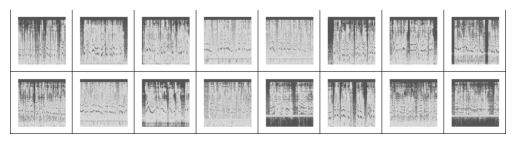

[0 0 0 1 0 1 1 0]


In [ ]:
vis_dataloader = DataLoader(train_dataset, shuffle=True,
                            batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
torch.save(model.state_dict(), )

## Evaluation PLots

In [ ]:
from utils import plotting

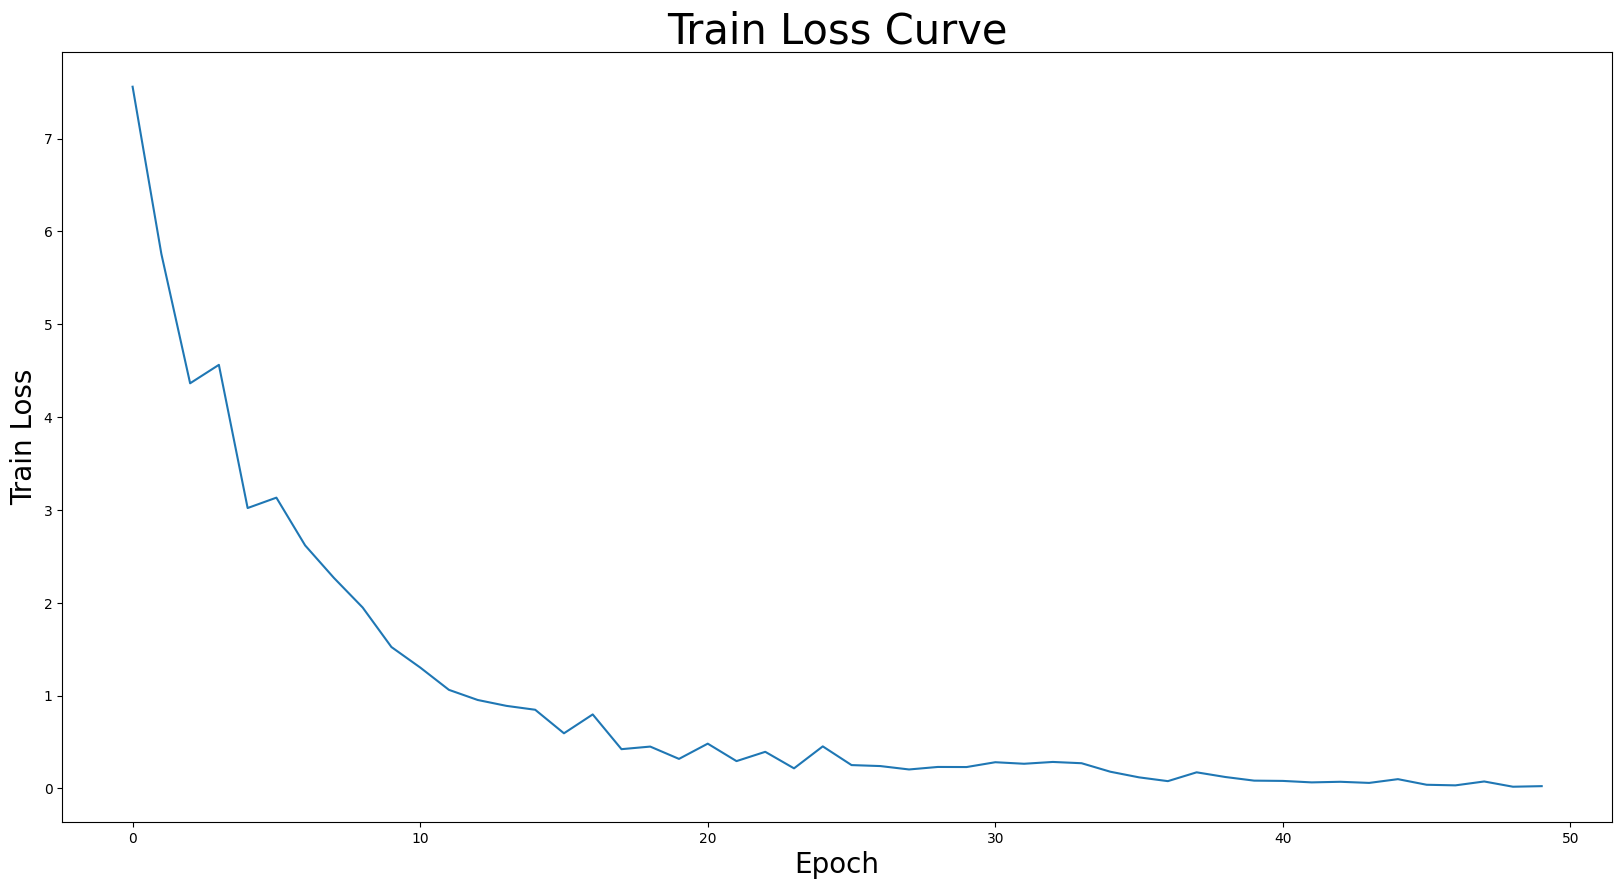

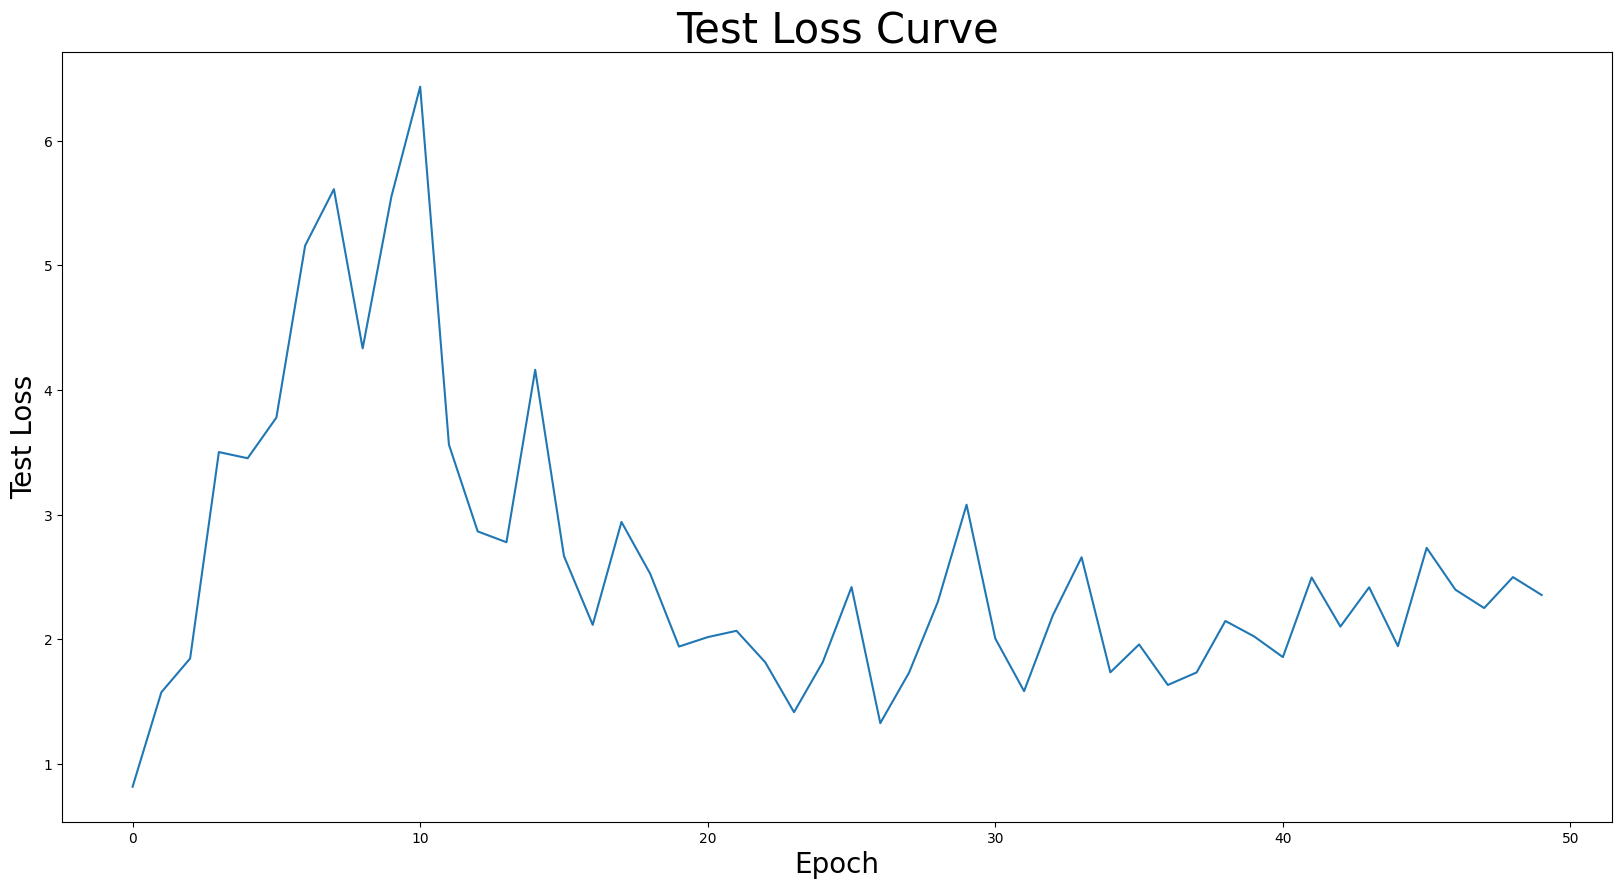

In [ ]:
epoch, value = zip(*train_loss_list)
plotting(epoch, value, 'Train Loss Curve', 'Epoch', 'Train Loss')
epoch, value = zip(*test_loss_list)
plotting(epoch, value, 'Test Loss Curve', 'Epoch', 'Test Loss')

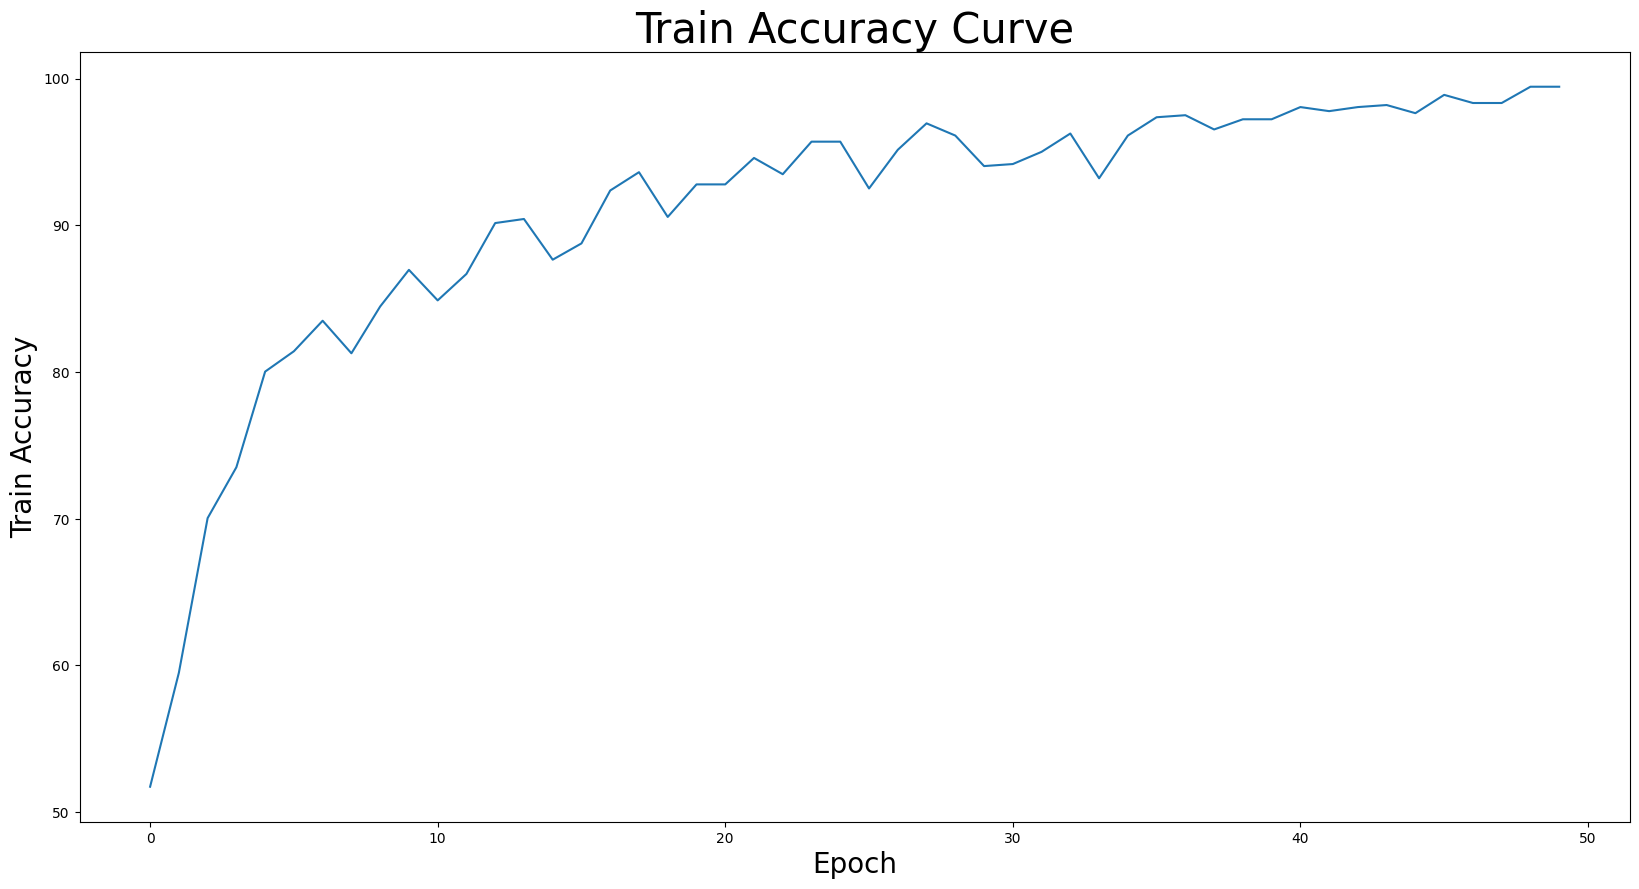

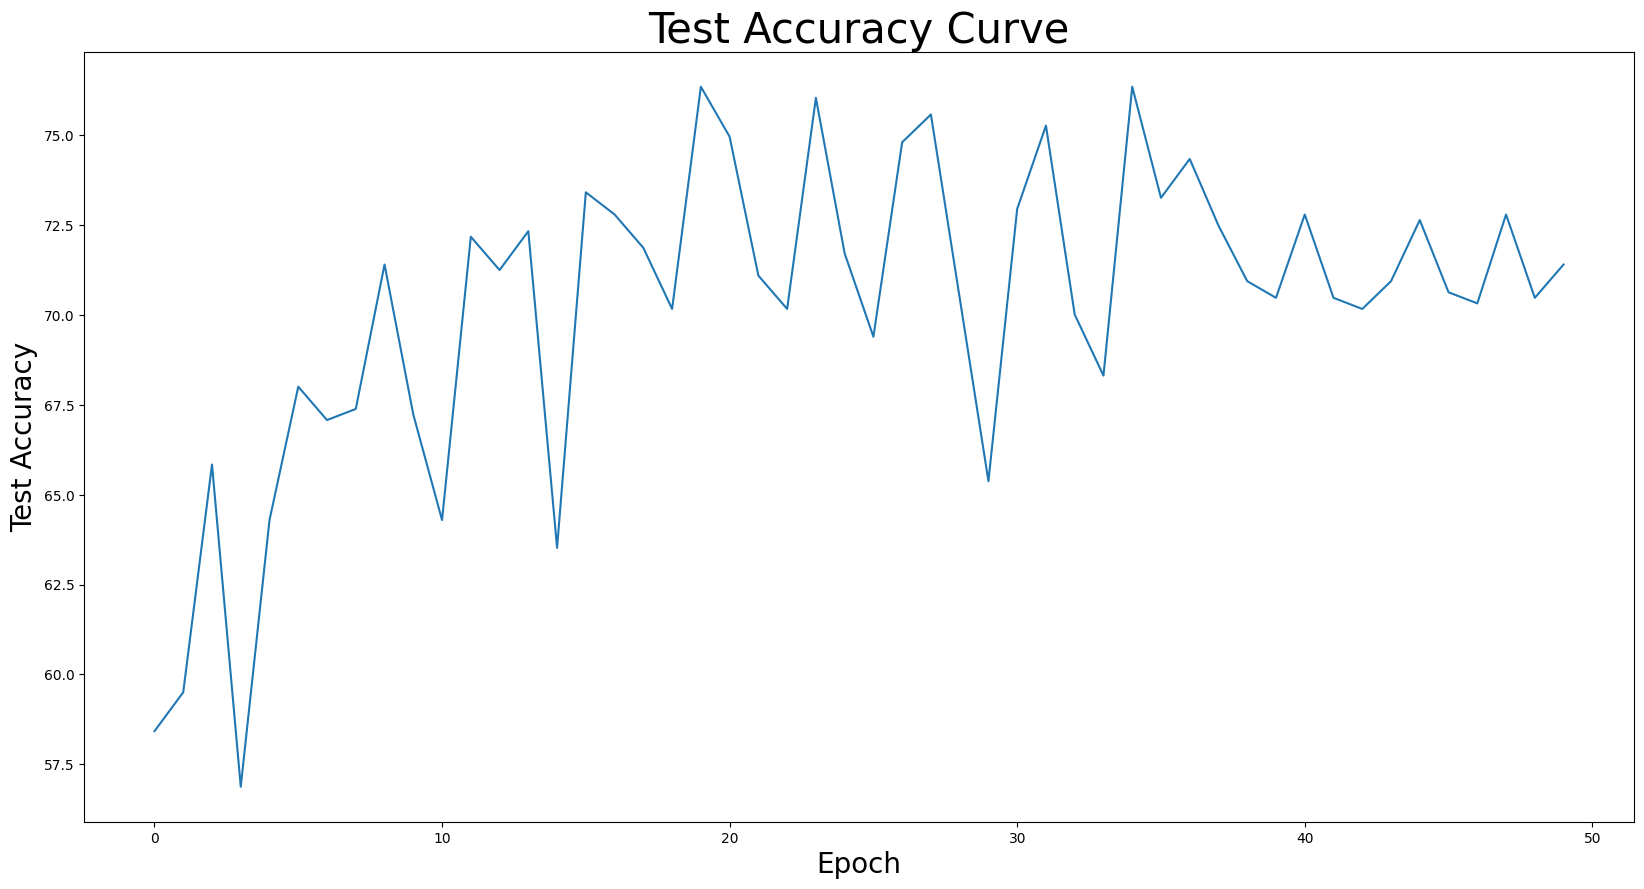

In [ ]:
epoch, value = zip(*train_accuracy_list)
plotting(epoch, value,'Train Accuracy Curve', 'Epoch', 'Train Accuracy')
epoch, value = zip(*test_accuracy_list)
plotting(epoch, value, 'Test Accuracy Curve', 'Epoch', 'Test Accuracy')